# Autoencoder for the Kolmogorov Flow

In this session, you will need to use what you learned in the previous notebooks to develop a particular neural network called an autoencoder.
The Kolmogorov flow is governed by the following equation:
\begin{align}
    \nabla \cdot \mathbf{u} &= 0\\
   \partial_t \mathbf{u} + \mathbf{u} \cdot \nabla \mathbf{u} &= -\nabla p + \frac{1}{Re} \Delta \mathbf{u} + \mathbf{f}
\end{align}
where $\mathbf{u} = (u,v)$ is the flow velocity over the domain $(x,y)\in \Omega = [0,2\pi]\times[0,2\pi]$ with periodic boundary conditions and $p$ is the pressure field.
In the Kolmogorov flow, the forcing term, $\mathbf{f}$ is $\mathbf{f} = (sin(k_fy),0)$.

The Kolmogorov flow admits a laminar solution $u= \frac{Re}{k_f^2} \sin(k_fy)$, $v=0$ which is unstable for large enough $Re$ and $k_f$.

In [11]:
from google.colab import drive
#Mount data files from your google drive to be able to use them
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import librairies

In [12]:
import numpy as np
import tensorflow as tf
# from datetime import datetime
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, AveragePooling2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.optimizers import Adam 



Parameter Selection

In [13]:
##FILE SELECTION##
Re=20.0 #choose between Re= 20.0, 30.0, 40.0, 50.0, 60.0, 100.0, 180.0

#T has different values depending on Re
if Re == 20.0 or Re == 30.0 or Re == 40.0:
  T=20000
else:
  T=2000

path_folder = '/content/drive/MyDrive/Capstone-Flow/Final_Product/' # path to folder in which flow data is situated
path = path_folder + f'Kolmogorov_Re{Re}_T{T}_DT01.h5'

##PARAMETER SELECTION##

dimensions= [8,4,2,1] #Specify the dimensions for each encoding layer (dim[3] = dimension of latent space)
#e.g. [16,8,4,2], [32,16,8,4], [64,32,16,8], [128,64,32,16], [256, 128, 64, 32]
#Decoding layer is mirror of encoding layer

activation_function = 'tanh' #specify which activation function to use
learning_rate = 0.001 # change to 0.0001 if using a latent space dimension of 32 and 64
number_epochs = 1000 #set high, early stopping function will stop iterations if it sees no visible change after 'patience_early_stopping' number of epochs
patience_early_stopping = 20 #how many epochs with no significant change before AE stops training
pooling = 'max' # set to 'max' or 'average'
if pooling == 'max':
  pooling_function = MaxPool2D
else:
  pooling_function = AveragePooling2D

# 2. Read dataset

In [14]:
hf = h5py.File(path,'r')
Nx = 24
Nu = 1
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
# u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
hf.close()
print(u_all.shape)

# normalize data
u_min = np.amin(u_all[:,:,:,0])
u_max = np.amax(u_all[:,:,:,0])
u_all[:,:,:,0] = (u_all[:,:,:,0] - u_min) / (u_max - u_min)
if Nu==2:
    v_min = np.amin(u_all[:,:,:,1])
    v_max = np.amax(u_all[:,:,:,1])
    u_all[:,:,:,1] = (u_all[:,:,:,1] - v_min) / (v_max - v_min)


(4000, 24, 24, 1)


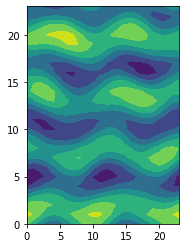

In [15]:
# visualization of the dataset
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all[50,:,:,0])
# ax2 = fig.add_subplot(122)
# ax2.contourf(u_all[0,:,:,1])

# 3. Prepare dataset

In [16]:
val_ratio = int(np.round(0.75*len(u_all)))
test_ratio = int(np.round(0.95*len(u_all)))

u_train = u_all[:val_ratio,:,:,:].astype('float32')
u_val = u_all[val_ratio:test_ratio,:,:,:].astype('float32')
u_test = u_all[test_ratio:,:,:,:].astype('float32')
#del u_all


# 4. Define the network

In [ ]:
input_img = Input(shape=(Nx,Nx,Nu))

nb_layer = 0

x = Conv2D(dimensions[0],(3,3), padding='same', activation=activation_function)(input_img)
x = pooling_function((2,2), padding='same')(x)
x = Conv2D(dimensions[1],(3,3), padding='same', activation=activation_function)(x)
x = pooling_function((2,2), padding='same')(x)
x = Conv2D(dimensions[2],(3,3), padding='same', activation=activation_function)(x)
x = pooling_function((2,2), padding='same')(x)
x = Conv2D(dimensions[3],(3,3), padding='same', activation=activation_function)(x)
encoded = pooling_function((3,3), padding='same')(x)

x = Conv2DTranspose(dimensions[3],(3,3), padding='same', activation=activation_function)(encoded)
x = UpSampling2D((3,3))(x)
x = Conv2DTranspose(dimensions[2],(3,3), padding='same', activation=activation_function)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(dimensions[1],(3,3), padding='same', activation=activation_function)(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(dimensions[0],(3,3), padding='same', activation=activation_function)(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2DTranspose(Nu,(3,3), activation='linear', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img,decoded)
encoder = tf.keras.models.Model(input_img,encoded)

# definition of the decoder
encoded_input = Input(shape=(1,1,encoded.shape[3]))
deco = autoencoder.layers[-7](encoded_input) # we re-use the same layers as the ones of the autoencoder
for i in range(6):
    deco = autoencoder.layers[-6+i](deco)

decoder = tf.keras.models.Model(encoded_input,deco)

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 24, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 4)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 2)           74  

# 5. Training the Network
We use the difference between the network output and the real image to calculate or cost/loss function. As an optimizier we choose the AdamOptimizer and tell it which function value to minimize

In [ ]:
autoencoder.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')

In [ ]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_early_stopping)

In [ ]:
nb_epochs = number_epochs
batch_size = 20
hist = autoencoder.fit(u_train, u_train, epochs=nb_epochs, batch_size=batch_size,
                shuffle=True,validation_data=(u_test, u_test),
                       verbose=1,
                       callbacks=[model_checkpoint_callback,early_stop_callback])

Epoch 1/1000
38/38 [==============================] - 2s 25ms/step - loss: 0.0709 - val_loss: 0.0394
Epoch 2/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0337 - val_loss: 0.0287
Epoch 3/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0251 - val_loss: 0.0222
Epoch 4/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0206 - val_loss: 0.0188
Epoch 5/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0185 - val_loss: 0.0175
Epoch 6/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0176 - val_loss: 0.0168
Epoch 7/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0170 - val_loss: 0.0163
Epoch 8/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.0166 - val_loss: 0.0159
Epoch 9/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 10/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.0160 - val_lo

KeyboardInterrupt: ignored

In [ ]:
loss_history = hist.history['loss']
val_history = hist.history['val_loss']
%matplotlib inline
plt.plot(loss_history,'b')
plt.plot(val_history,'r')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 6. Visualization of some prediction cases

In [ ]:
y_nn = autoencoder.predict(u_test[0:1,:,:,:])
print(y_nn.shape)
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(y_nn[0,:,:,0])
ax = fig.add_subplot(122)
ax.contourf(u_test[0,:,:,0])


7. Final error of the autoencoder

In [ ]:
print(f'AE error: {loss_history[-1]}')